# Optimal Control of the Lotka-Volterra equations

In this tutorial we study an optimal control problem for the [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) frequently used to describe the dynamics of biological systems in which two species interact: a predator ($y$) and a prey ($x$). 

The dynamics considered, taken from the work of [Aitziber Ibanez](https://www.tandfonline.com/doi/full/10.1080/17513758.2016.1226435) is:

\begin{equation}
(1) \quad \left\{
\begin{array}{l}
\dot x = p_0 x - p_1 xy - p_4 x u\\
\dot y = p_2 xy - p_3 y - p_5 y u\\
\end{array}
\right.
\end{equation}

where $p_i > 0$ and $0 <= \vert u\vert <= 1$ is a control variable describing our hunting capabilities assumed to be proportional for the two species (fishing net scenario).

**NOTE**: we used the symbols $p_i$ for all parameters as its the default symbol used in `heyoka.py`, and thus allows consistency in notation throughout the notebook.

We are interested in finding $u(t)$ in the functional space of piecewice continuous functions such that the system is steered into a terminal state $x_f, y_f$ in minimal time when starting from some intial condition $x_0, y_0$.

More formally, we consider the following optimal control problem (**OCP**):

\begin{array}{rl}
\mbox{find:}  & u(t), t_f \\
\mbox{subject to (dynamics):}   &  \dot x = p_0 x - p_1 xy - p_4 x u\\
                     &  \dot y = p_2 xy - p_3 y - p_5 y u\\
\mbox{subject to (boundary conditions):}   &  x(0) = x_0, \quad  x(t_f) = x_f\\
    &  y(0) = y_0, \quad  y(t_f) = y_f\\
    & 0 <= \vert u\vert <= 1 \\
\mbox{to minimize:}   &  t_f \\  
\end{array}

To solve the above **OCP** we will apply Pontryagin maximum principle ([**PMP**](https://en.wikipedia.org/wiki/Pontryagin%27s_maximum_principle)), accounting for the fact we have a minimization problem by maximizing $-t_f$ instead. We will thus eventually transform the problem above into
a two-point boudary value problem (**TPBVP**) of an augmented set of ordinary differential equation (**ODE**) which we will solve using `heyoka.py`. 
Let us start importing a few core tools:

In [1]:
import heyoka as hy
import numpy as np
from matplotlib import pyplot as plt

import sympy.simplify as pretty

# Deriving the augmented dynamics

The straightforward application of the **PMP** requires the introduction of auxiliary functions $\boldsymbol\lambda(t)$ and of a Hamiltonian which, in the case of a minimum time problem is:

$$
\mathcal H(\mathbf x, \boldsymbol\lambda, u) = \mathbf f \cdot \boldsymbol\lambda - 1
$$
where we indicated with $ \mathbf f$ the r.h.s. of the dynamics.

Let us then define the ecosystem state, the co-states (or augmented states, essentially some form of continuous version of Lagrange multipliers) $\lambda_x, \lambda_y$ and the dynamics:

In [2]:
# Define the symbolic variables x, y and th.
x, y = hy.make_vars("x", "y")

# the co-states lx, ly 
lx, ly = hy.make_vars("lambda_x", "lambda_y")

# the control
u, = hy.make_vars("u")

# and the dynamics fx, fy
fx = hy.par[0]*x - hy.par[1]*x*y - x * hy.par[4] * u
fy = hy.par[2]*x*y - hy.par[3]*y - y * hy.par[5] * u

and the expression for the Hamiltonian:

In [3]:
# The Hamiltonian
H = fx*lx + fy*ly - 1
print("The Hamiltonian:")
pretty(H.__repr__())

The Hamiltonian:


-lambda_x*x*(-p0 + p1*y + p4*u) - lambda_y*y*(-p2*x + p3 + p5*u) - 1.0

Note how in *heyoka.py* expression system system parameters are indicated with the symbols $p_i$ in the screen output.

According to the **PMP** the value of the control $u$, along an optimal trajectory, is such that:

$$
u^* = \max_{u\in\mathcal U} \mathcal H(\mathbf x, \boldsymbol\lambda, u)
$$
where we have introduced the space of admissible controls as the closed interval $\mathcal U = [0,1]$. In our case we get, quite simply:
$$
u^*(\mathbf x, \boldsymbol\lambda) = 
\left\{\begin{array}{ll}
1 & -(p_4 x\lambda_x+p_5 y \lambda_y) \gt 0 \\
0 & -(p_4 x\lambda_x+p_5 y \lambda_y) \lt 0
\end{array}
\right.
$$
The value of the control will then switch between the extreme values 0 and 1 whenever the switching function $S(\mathbf x, \boldsymbol \lambda) = -(p_4 x\lambda_x+p_5 y \lambda_y)$ changes sign. 

We implement two python functions to compute the switching function and the maximized hamiltonian. They will be handy later on.



In [4]:
def _switching_function(x,y,lx,ly,p):
    return -(p[4]*x*lx+p[5]*y*ly)
             
def switching_function(x,y,lx,ly,p):
    vectorized = np.vectorize(lambda x,y,lx,ly: _switching_function(x,y,lx,ly,p))
    return vectorized(x,y,lx,ly)

def _hamiltonian(x,y,lx,ly,p):
    sw_v = switching_function(x,y,lx,ly,p)
    u_opt = 0
    if sw_v > 0:
        u_opt = 1
    return hy.eval(H, {"x":x, "y":y, "lambda_x":lx, "lambda_y":ly, "u":u_opt}, p)

def hamiltonian(x,y,lx,ly,p):
    vectorized = np.vectorize(lambda x,y,lx,ly: _hamiltonian(x,y,lx,ly,p))
    return vectorized(x,y,lx,ly)

The equations of motion for the augmented state ($\mathbf x, \boldsymbol \lambda$) are the Hamilton's equations:
$$
\begin{array}{l}
\dot {\mathbf x} = \frac{\partial \mathcal H}{\partial \boldsymbol \lambda} \\
\dot {\boldsymbol \lambda} = - \frac{\partial \mathcal H}{\partial \mathbf x} 
\end{array}
$$
let us compute them:

In [5]:
# We compute the co-state equations
flx = -hy.diff(H, "x")
fly = -hy.diff(H, "y")

In [6]:
print("Co-state dynamics (1):")
pretty((flx).__repr__())

Co-state dynamics (1):


lambda_x*(-p0 + p1*y + p4*u) - lambda_y*p2*y

In [7]:
print("Co-state dynamics (2):")
pretty((fly).__repr__())

Co-state dynamics (2):


lambda_x*p1*x + lambda_y*(-p2*x + p3 + p5*u)

Putting everything together (i.e. substituting the expression for the optimal $u^*$ found via the **PMP** into the augmented equations) we get:
$$
(2) \quad \left\{
\begin{array}{l}
\dot x = p_0 x - p_1 xy - p_4 x u^*\\
\dot y = p_2 xy - p_3 y - p_5 y u^*\\
\frac{d \lambda_x}{dt} = (-p_0 + p_1  y + p_4u^*)  \lambda_x - \lambda_y p_2  y   \\
\frac{d \lambda_y}{dt}  = p_1  x  \lambda_x +(-p_2  x + p_3 + p_5 u^*)  \lambda_y \\
\end{array}
\right.
$$
As dictated by Pontryagin's Theorem, a necessary condition for a trajectory to be optimal is that intial values $\boldsymbol \lambda_0$ exist such that the solution of the above ODE initial value problem (**IVP**) from $[\mathbf x_0, \boldsymbol \lambda_0]$ leads the system to the desired target state. 

Formally, we seek a root of the system of (three) nonlinear equations in the (three) unknowns $\boldsymbol \lambda_0, t_f$:
$$
(3)\qquad
\varphi(\boldsymbol \lambda_0, t_f) = 
\left[
\begin{array}{l}
x(t_f) - x_f \\
y(t_f) - y_f \\
\mathcal H (t_f)
\end{array}
\right]
$$
also called *shooting function* as finding its root requires solving multiple times an **IVP** in a "clever" trial and error iterative scheme. The added terminal condition on the Hamiltonian derives again from Pontryagin theory (this is a free time problem).

# Studying the uncontrolled system
Let us see what happens in an uncontrolled case. 

We will consider an initial population of 10 preys with growth rates $p_0= 1.1$, $p_1 = 0.2$ and 10 predators with growth rates $p_2 = 0.1$, $p_3 = 0.4$. 

Let us write the r.h.s. of Eq.(1). The parameters in the equations are indicated by the syntax `par[i]` and their numerical value will be set later.

In [8]:
fx_unc = hy.par[0]*x - hy.par[1]*x*y 
fy_unc = hy.par[2]*x*y - hy.par[3]*y

The actual EOM, in the heyoka.py syntax, can be specified as a list of tuples (variable, equation):

In [9]:
ode_sys_unc = [(x,fx_unc), (y, fy_unc)]

We now create the integrator object, using as initial conditions 10, 10.

In [10]:
ta = hy.taylor_adaptive(ode_sys_unc, [10, 10])
print(ta)

Taylor order            : 20
Dimension               : 2
Time                    : 0.0000000000000000
State                   : [10.000000000000000, 10.000000000000000]
Parameters  : [0.0000000000000000, 0.0000000000000000, 0.0000000000000000, 0.0000000000000000]



all parameters are set to zero by default, and we must now set theur numerical values:

In [11]:
ta.pars[0] = 1.1 # alpha
ta.pars[1] = 0.2 # beta
ta.pars[2] = 0.1 # delta
ta.pars[3] = 0.4 # gamma

We may now solve the **IVP**, since we want to record the state and show its trend we use the `propagate_grid` method which efficiently   

In [12]:
t_grid = np.linspace(0,20,1000)
outcome, min_h, max_h, steps, sol = ta.propagate_grid(t_grid)

... and plot the solution ... (note that we recorded also other quantities such as `outcome` etc.. but we are not really using them here)

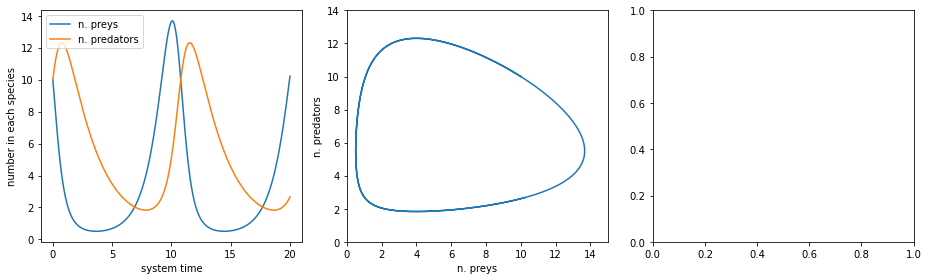

In [13]:
fig, axs = plt.subplots(1,3, figsize=(13,4))
preys_unc = sol[:,0]
predators_unc = sol[:,1]

axs[0].plot(t_grid, preys_unc, label="n. preys")
axs[0].plot(t_grid, predators_unc, label="n. predators")
axs[0].legend(loc=2)
axs[0].set_xlabel("system time")
axs[0].set_ylabel("number in each species")

axs[1].plot(preys_unc, predators_unc)
axs[1].set_xlabel("n. preys")
axs[1].set_ylabel("n. predators")
axs[1].set_xlim([0,15])
axs[1].set_ylim([0,14])

plt.tight_layout() 

# Controlling the pray-predator dynamics
Let us try to steer the system so that we have in the shortest possible time an ecosystem with 10 prays and 4 predators. 

For this, as explained above, we must find find suitable initial values for the costates $\lambda_x, \lambda_y$ and for the final time $t_f$ so that, solving Eq.(2) we get $x(t_f) = 10$,  $y(t_f)=4$ and $\mathcal H(t_f)=0$. 

Let us define our ODE first:

In [14]:
# Dynamics
fx = hy.par[0]*x - hy.par[1]*x*y - x * hy.par[4] *  hy.par[6]
fy = hy.par[2]*x*y - hy.par[3]*y - y * hy.par[5] *  hy.par[6]
flx = (-hy.par[0] + hy.par[1]*y + hy.par[6] * hy.par[4]) * lx - hy.par[2]*ly*y
fly = hy.par[1]*x*lx + (-hy.par[2]*x + hy.par[3] + hy.par[6] * hy.par[5]) * ly
ode_sys = [(x,fx), (y, fy), (lx, flx), (ly, fly)]

# Boundary conditions
# Initial 
x_0, y_0 = 10, 10
# Final  
x_t, y_t = 10, 4

# System parameters
p0,p1,p2,p3,p4,p5,p6 = ps = [1.1,0.2, 0.1,0.4,0.03,0.03, 0]

# A random choice for the initial costates
lx_0, ly_0  =-1.105, -1.6274561403508774

We have added three parameters to the system. The first ones are `par[4]` and `par[5]` representing the values of $p_4, p_5$. Then, `par[6]` is the value of the optimal control $u^*$ effectively determining which one of two different systems of ODEs gets propagated. 

We now build the system of equations taking care to define a terminal event detecting the change in sign of the switching function and thus changing the control value accordingly.

In [15]:
# Here we record the switching times
switch_times = []

def switch_callback(ta, t, mr, log_times):
    if not mr:
        if ta.pars[6]==0.:
            ta.pars[6] = 1.
        else:
            ta.pars[6]=0.
        if log_times:
            switch_times.append(t)
        
switching_event = hy.t_event(x * lx * hy.par[4] + y * ly * hy.par[5], callback = lambda ta,t,mr: switch_callback(ta, t, mr, True))

# the integrator
ta = hy.taylor_adaptive(ode_sys, [x_0, y_0, lx_0, ly_0], pars = ps, t_events = [switching_event])
# we must set the initial value of the parameter $u^*$ to its optimal value at t=0
ta.pars[6] = np.heaviside(switching_function(x_0,y_0,lx_0,ly_0, ps), 1.)
print(ta)

Taylor order            : 20
Dimension               : 4
Time                    : 0.0000000000000000
State                   : [10.000000000000000, 10.000000000000000, -1.1050000000000000, -1.6274561403508774]
Parameters  : [1.1000000000000001, 0.20000000000000001, 0.10000000000000001, 0.40000000000000002, 0.029999999999999999, 0.029999999999999999, 1.0000000000000000]
N of terminal events    : 1



We now integrate the system. The resulting trajectory will be optimal in a sense, only not respecting our requested boundary conditions, since the final time $t_f$ and the initial values of the costates were radnomly chosen.

In [16]:
t_grid = np.linspace(0,30,1000)
outcome, min_h, max_h, steps, sol = ta.propagate_grid(t_grid)

and replot the result, comparing it to the previous uncontrolled system.

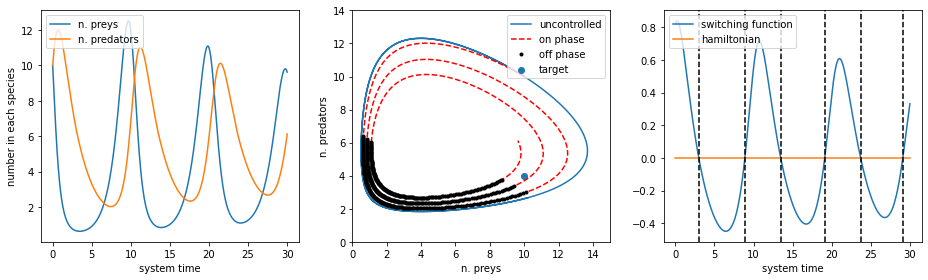

In [17]:
fig, axs = plt.subplots(1,3, figsize=(13,4))
preys = sol[:,0]
predators = sol[:,1]
lpreys = sol[:,2]
lpredators = sol[:,3]

sf_num = switching_function(preys, predators, lpreys, lpredators, ps)
H_num = hamiltonian(preys, predators, lpreys, lpredators, ps)
mask_on = sf_num > 0
mask_off = sf_num < 0

axs[0].plot(t_grid, preys, label="n. preys")
axs[0].plot(t_grid, predators, label="n. predators")
axs[0].legend(loc=2)
axs[0].set_xlabel("system time")
axs[0].set_ylabel("number in each species")

axs[1].plot(preys_unc, predators_unc, label="uncontrolled")
axs[1].plot(preys, predators, 'r--', label = "on phase")
axs[1].plot(preys[mask_off], predators[mask_off], 'k.', label = "off phase")
axs[1].set_xlabel("n. preys")
axs[1].set_ylabel("n. predators")
axs[1].set_xlim([0,15])
axs[1].set_ylim([0,14])
axs[1].scatter([x_t], [y_t], label='target')
axs[1].legend(loc=1)

axs[2].plot(t_grid, sf_num, label="switching function")
axs[2].plot(t_grid, H_num, label="hamiltonian")
for time in switch_times:
    axs[2].axvline(x=time, color='k', linestyle='--')
axs[2].set_xlabel("system time")
axs[2].legend(loc=2)

plt.tight_layout() 

# Implementing a single shooting method
Above we have produced an optimal trajectory, only not the one we looked for since we want to achieve the terminal conditions $x_f = 10, y_f=4$ and (free time) $H_f=0$. 
The choice we made for $\lambda_{x0}$, $\lambda_{y0}$, $t_f$ was not a good one, we need to change it up to when Eq.(3) is actually satisfied. 

In this case, to showcase the possibilities offered by *heyoka.py*, we will vary $\lambda_x$, find $\lambda_y$ from the condition $\mathcal H_f = \mathcal H_0 = 0$ and find $t_f$ as the time along the generated trajectory when the difference between the state and the target is minimal (a terminal event).

This reduces the free *shooting parameters* in Eq.(3) from three to one only: $\lambda_x$. 

The following holds (from $\mathcal H_f = \mathcal H_0=0$):
$$
\lambda_{y0} = \frac{x\lambda_{x0}(p_0-p_1 y_0-p_4 u^*_0-1)}{y_0(-p_2x_0+p_3+p_5 u^*_0)}
$$
and it is implemented in the function below:

In [18]:
def find_lambda_y0(x_0,y_0,lx_0,p):
    #we assume u*=0
    ly_0 = (x_0*lx_0*(p[0]-p[1]*y_0)-1)/y_0/(-p[2]*x_0+p[3])
    if _switching_function(x_0,y_0,lx_0,ly_0,p) < 0:
        #the assumption holds
        return ly_0
    ly_0 = (x_0*lx_0*(p[0]-p[1]*y_0-p[4])-1)/y_0/(-p[2]*x_0+p[3]+p[5])
    if _switching_function(x_0,y_0,lx_0,ly_0,p) > 0:
        #the assumption holds
        return ly_0
    raise ValueError

We also need to introduce a distance event triggering when the derivative of the distance is zero, hence at the maximum and minimum distance points.

In [19]:
def distance_callback(ta, t, mr):
    candidates_t.append(t)
    candidates_d.append((ta.state[0]-x_t)**2 + (ta.state[1]-y_t)**2)

# This is the new "distance" event
distance_event = hy.t_event((x- x_t)*fx + (y-y_t)*fy, callback = distance_callback)

# We also redefine the switching event as we have no need to log the switching times (this is optional and has not real impact in this case)
switching_event_no_log = hy.t_event(x * lx * hy.par[4] + y * ly * hy.par[5], callback = lambda ta,t,mr: switch_callback(ta, t, mr, False))

Let us check that all is in order performing again the same integration and visualizing the new event triggers ....

In [20]:
ta = hy.taylor_adaptive(ode_sys, [x_0, y_0, lx_0, ly_0], pars=ps, t_events = [switching_event_no_log, distance_event])
# we must set the initial value of the parameter $u^*$ to its optimal value at t=0
ta.pars[6] = np.heaviside(switching_function(x_0,y_0,lx_0,ly_0, ps), 1.)
print(ta)

Taylor order            : 20
Dimension               : 4
Time                    : 0.0000000000000000
State                   : [10.000000000000000, 10.000000000000000, -1.1050000000000000, -1.6274561403508774]
Parameters  : [1.1000000000000001, 0.20000000000000001, 0.10000000000000001, 0.40000000000000002, 0.029999999999999999, 0.029999999999999999, 1.0000000000000000]
N of terminal events    : 2



In [21]:
t_grid = np.linspace(0,35,1000)
candidates_d = []
candidates_t = []
outcome, min_h, max_h, steps, sol = ta.propagate_grid(t_grid)

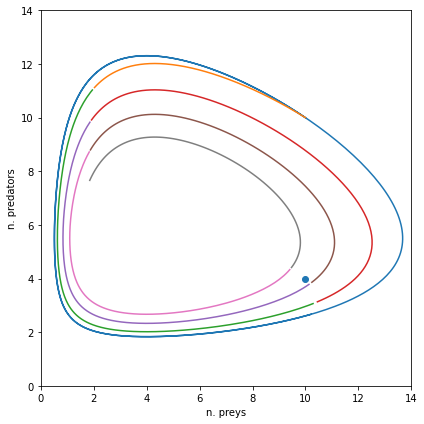

In [22]:
fig, axs = plt.subplots(1,1, figsize=(6,6))
preys = sol[:,0]
predators = sol[:,1]
lpreys = sol[:,2]
lpredators = sol[:,3]

sf_num = switching_function(preys, predators, lpreys, lpredators, ps)
H_num = hamiltonian(preys, predators, lpreys, lpredators, ps)
axs.plot(preys_unc, predators_unc)

candidates_t.insert(0,0)
candidates_d.insert(0,np.inf)

for i in range(len(candidates_t)-1):
    mask_on = (t_grid >= candidates_t[i])&(t_grid <= candidates_t[i+1])
    axs.plot(preys[mask_on], predators[mask_on], '-')
axs.scatter([x_t], [y_t])
axs.set_xlabel("n. preys")
axs.set_ylabel("n. predators")
axs.set_xlim([0,14])
axs.set_ylim([0,14])


plt.tight_layout() 

In [23]:
def reduced_shooting_function(x_0, y_0, lx_0, ps):
    global candidates_t
    global candidates_d
    global ta

    # We reset the time
    ta.time = 0
    # We compute the initiqal value for the y co-state (form H=0)
    ly_0 = find_lambda_y0(x_0, y_0, lx_0, ps)
    # We compute the initial value of the optimal control
    ta.pars[6] = np.heaviside(switching_function(x_0,y_0,lx_0,ly_0, ps), 1.)

    # We set the initial conditions
    ta.state[0] = x_0; ta.state[1] = y_0; ta.state[2] = lx_0; ta.state[3] = ly_0
    # We reset the candidates final times and distances
    candidates_t = []
    candidates_d = []
    # define the time grid
    t_grid = np.linspace(0,35,1000)
    # Perform the integration
    outcome, min_h, max_h, steps, sol = ta.propagate_grid(t_grid)
    # We return the minimum distance
    return np.min(candidates_d)
    

In [24]:
from scipy.optimize import minimize
res = minimize(lambda lx_0: reduced_shooting_function(x_0, y_0, lx_0, ps), -0.47, tol=1e-8)
res

      fun: 1.903079140652692e-15
 hess_inv: array([[0.01440261]])
      jac: array([3.25875263e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([-0.47906457])

In [25]:
idx = np.argmin(candidates_d)
tf = candidates_t[idx]
lx_0 = res.x
# We reset the time
ta.time = 0
# We compute the inititial value for the y co-state (form H=0)
ly_0 = find_lambda_y0(x_0, y_0, lx_0, ps)

switch_times = []
ta = hy.taylor_adaptive(ode_sys, [x_0, y_0,lx_0, ly_0], pars=ps, t_events = [switching_event])
# We compute the initial value of the optimal control
ta.pars[6] = np.heaviside(switching_function(x_0,y_0,lx_0,ly_0, ps), 1.)

# define the time grid
t_grid = np.linspace(0,tf,1000)
# Perform the integration
outcome, min_h, max_h, steps, sol = ta.propagate_grid(t_grid)

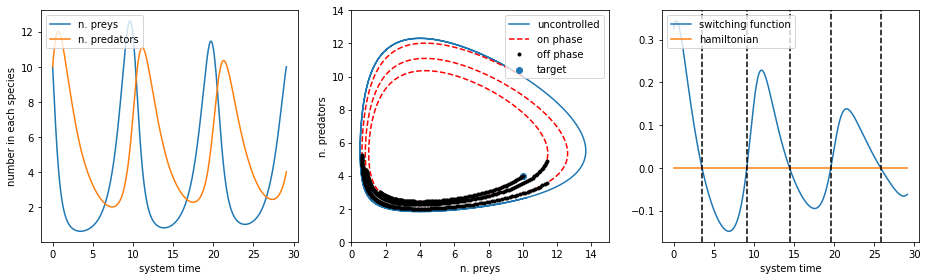

In [26]:
fig, axs = plt.subplots(1,3, figsize=(13,4))
preys = sol[:,0]
predators = sol[:,1]
lpreys = sol[:,2]
lpredators = sol[:,3]

sf_num = switching_function(preys, predators, lpreys, lpredators, ps)
H_num = hamiltonian(preys, predators, lpreys, lpredators, ps)
mask_on = sf_num > 0
mask_off = sf_num < 0

axs[0].plot(t_grid, preys, label="n. preys")
axs[0].plot(t_grid, predators, label="n. predators")
axs[0].legend(loc=2)
axs[0].set_xlabel("system time")
axs[0].set_ylabel("number in each species")

axs[1].plot(preys_unc, predators_unc, label="uncontrolled")
axs[1].plot(preys, predators, 'r--', label = "on phase")
axs[1].plot(preys[mask_off], predators[mask_off], 'k.', label = "off phase")
axs[1].scatter([x_t], [y_t], label='target')
axs[1].set_xlabel("n. preys")
axs[1].set_ylabel("n. predators")
axs[1].set_xlim([0,15])
axs[1].set_ylim([0,14])
axs[1].legend(loc=1)



axs[2].plot(t_grid, sf_num, label="switching function")
axs[2].plot(t_grid, H_num, label="hamiltonian")
for time in switch_times:
    axs[2].axvline(x=time, color='k', linestyle='--')
axs[2].set_xlabel("system time")
axs[2].legend(loc=2)

plt.tight_layout()
